<a href="https://colab.research.google.com/github/ImanFakury/imanRepository/blob/master/DeepLearning/CHW4/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Iman Alizadeh Fakouri(401102134)

____

# 🔴 **Import Libs**

In [ ]:
!pip uninstall -y torchtext torchmetrics torchdata torchaudio torchvision peft

!pip install torch==2.1.0
!pip install torchtext==0.16.0
!pip install torchmetrics==1.6.0
!pip install torchdata==0.7.0


Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0
Found existing installation: torchmetrics 1.6.0
Uninstalling torchmetrics-1.6.0:
  Successfully uninstalled torchmetrics-1.6.0
Found existing installation: torchdata 0.7.0
Uninstalling torchdata-0.7.0:
  Successfully uninstalled torchdata-0.7.0
  Using cached torchtext-0.16.0-cp310-cp310-manylinux1_x86_64.whl.metadata (7.5 kB)
  Using cached torchdata-0.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached torchtext-0.16.0-cp310-cp310-manylinux1_x86_64.whl (2.0 MB)
Using cached torchdata-0.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Using cached torchmetrics-1.6.0-py3-none-any.whl.metadata (20 kB)
Using cached torchmetrics-1.6.0-py3-none-any.whl (926 kB)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchtext
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torch.nn import functional as F
import tqdm
import torchmetrics as tm

In [ ]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
2.1.0+cu121
0.16.0+cpu


In [ ]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.1.0+cu121
torchtext --> 0.16.0+cpu
tqdm --> 4.67.1


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

In [ ]:
train_data.shape

(36718, 1)

## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter

tokenizer = get_tokenizer("basic_english")

def tokenize_data(data):
    for item in data:
        yield tokenizer(item['text'])
def count_token_frequencies(data):
    counter = Counter()
    for tokens in tokenize_data(data):
        counter.update(tokens)
    return counter
def build_filtered_vocab(counter, min_freq, specials):
    filtered_tokens = [token for token, freq in counter.items() if freq >= min_freq]
    filtered_tokens = specials + filtered_tokens
    vocab = build_vocab_from_iterator([filtered_tokens])
    return vocab

token_freqs = count_token_frequencies(train_data)
special_tokens = ["<unk>", "<pad>", "<bos>", "<eos>"]
vocab = build_filtered_vocab(token_freqs, min_freq=5, specials=special_tokens)

vocab.set_default_index(vocab["<unk>"])


In [ ]:
len(vocab)

20925

## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [ ]:
def calculate_statistics(data):
    num_documents = len(data)
    total_words = 0
    document_lengths = []

    for item in data:
        tokens = tokenizer(item['text'])
        total_words += len(tokens)
        document_lengths.append(len(tokens))

    avg_document_length = total_words / num_documents

    return {
        "num_documents": num_documents,
        "total_words": total_words,
        "avg_document_length": avg_document_length,
    }

train_stats = calculate_statistics(train_data)
valid_stats = calculate_statistics(valid_data)
test_stats = calculate_statistics(test_data)
print("Train Stats:", train_stats)
print("Validation Stats:", valid_stats)
print("Test Stats:", test_stats)

Train Stats: {'num_documents': 36718, 'total_words': 2051665, 'avg_document_length': 55.87627321749551}
Validation Stats: {'num_documents': 3760, 'total_words': 214665, 'avg_document_length': 57.09175531914894}
Test Stats: {'num_documents': 4358, 'total_words': 242156, 'avg_document_length': 55.56585589720055}


### 🟡 Analyze the most common and least common words in the dataset.

In [ ]:
def analyze_vocabulary(vocab):
    sorted_vocab = sorted(vocab.get_stoi().items(), key=lambda x: x[1])
    most_common = sorted_vocab[:10]
    least_common = sorted_vocab[-10:]
    return most_common, least_common

most_common_words, least_common_words = analyze_vocabulary(vocab)
print("Most Common Words:", most_common_words)
print("Least Common Words:", least_common_words)

Most Common Words: [('!', 0), ('#', 1), ('$', 2), ('%', 3), ('&', 4), ("'", 5), ('(', 6), (')', 7), ('*', 8), ('+', 9)]
Least Common Words: [('≤', 20915), ('☉', 20916), ('♭', 20917), ('♯', 20918), ('〈', 20919), ('〉', 20920), ('・', 20921), ('大空', 20922), ('\ufeff', 20923), ('～', 20924)]


## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
import torch

def reshape_dataset(data, vocab, tokenizer):
    tokenized_data = [
        [vocab[token] for token in tokenizer(item['text'])]
        for item in data
    ]

    inputs = [torch.tensor(tokens[:-1], dtype=torch.int64) for tokens in tokenized_data]
    targets = [torch.tensor(tokens[1:], dtype=torch.int64) for tokens in tokenized_data]
    max_len = max(len(sentence) for sentence in inputs)

    padded_inputs = torch.stack([
        torch.cat([sentence, torch.tensor([vocab['<PAD>']] * (max_len - len(sentence)), dtype=torch.int64)])
        if len(sentence) < max_len else sentence
        for sentence in inputs
    ])

    return padded_inputs[:,:32], padded_inputs[:,1:33]

train_inputs, train_targets = reshape_dataset(train_data, vocab, tokenizer)
valid_inputs, valid_targets = reshape_dataset(valid_data, vocab, tokenizer)
test_inputs, test_targets = reshape_dataset(test_data, vocab, tokenizer)

print(f'train_inputs shape: {train_inputs.shape}')
print(f'train_targets shape: {train_targets.shape}')

train_inputs shape: torch.Size([36718, 32])
train_targets shape: torch.Size([36718, 32])


In [ ]:
train_inputs[1]

tensor([  926, 19880,  4022,  9691,   925,   925,   925,   925,   925,   925,
          925,   925,   925,   925,   925,   925,   925,   925,   925,   925,
          925,   925,   925,   925,   925,   925,   925,   925,   925,   925,
          925,   925])

In [ ]:
train_targets[3]

tensor([13145, 19880,   647,   925,  4022,     6, 10447,   925,    10, 11406,
           13, 19880, 13402, 18874,  2517,   647,     7,    10,  4439, 15685,
        19070,  1988, 19880,  4022,  9691, 13694, 10446,    10, 10336,   934,
        18603, 16357])

In [ ]:
train_data[3]

{'text': ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n'}

In [ ]:
def decode_tokens(tokens, vocab, remove_special_tokens=True):
    words = [vocab.get_itos()[token.item()] for token in tokens]

    if remove_special_tokens:
        words = [word for word in words if word not in ['<unk>', '<pad>', '<bos>', '<eos>']]

    return " ".join(words)

decoded_input = decode_tokens(train_inputs[3], vocab)
decoded_targets = decode_tokens(train_targets[3], vocab)
print(f"Decoded input: {decoded_input}")
print()
print(f"Decoded target: {decoded_targets}")


Decoded input: senjō no valkyria 3 chronicles ( japanese , lit . valkyria of the battlefield 3 ) , commonly referred to as valkyria chronicles iii outside japan , is a tactical

Decoded target: no valkyria 3 chronicles ( japanese , lit . valkyria of the battlefield 3 ) , commonly referred to as valkyria chronicles iii outside japan , is a tactical role


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [ ]:
class LanguageModelDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_batch = self.inputs[idx]
        target_batch = self.targets[idx]
        return input_batch, target_batch

In [ ]:
from torch.utils.data import DataLoader
train_dataset = LanguageModelDataset(train_inputs, train_targets)
valid_dataset = LanguageModelDataset(valid_inputs, valid_targets)
test_dataset = LanguageModelDataset(test_inputs, test_targets)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
num_batches = len(train_loader)
print(f"Number of batches in train_loader: {num_batches}")
for batch_idx, (input_batch, target_batch) in enumerate(train_loader):
    print(f"Input batch shape: {input_batch.shape}")
    print(f"Target batch shape: {target_batch.shape}")
    if batch_idx == 0:
        break


Number of batches in train_loader: 1148
Input batch shape: torch.Size([32, 32])
Target batch shape: torch.Size([32, 32])


# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [ ]:
import torch
import torch.nn as nn

class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out)
        return out


# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [ ]:
import torch.optim as optim
model = LanguageModel(len(vocab), 128, 256, 2, 0.3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
def calculate_perplexity(loss):
    return torch.exp(loss)
batch_size = 16
epochs = 10
learning_rate = 0.001

In [ ]:
torch.cuda.empty_cache()


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
import torch
import torch.nn.functional as F
import tqdm

def calculate_perplexity(loss):
    return torch.exp(loss)

def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None, device=None):
    model.train()
    loss_train = AverageMeter()
    total_perplexity = 0.0
    total_batches = 0

    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = outputs.view(-1, outputs.size(-1))
            targets = targets.view(-1)
            loss = loss_fn(outputs, targets)
            perplexity = calculate_perplexity(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train.update(loss.item(), n=inputs.size(0) * inputs.size(1))
            total_perplexity += perplexity.item()
            total_batches += 1
            tepoch.set_postfix(loss=loss_train.avg, perplexity=total_perplexity / total_batches)

    avg_perplexity = total_perplexity / total_batches

    return model, loss_train.avg, avg_perplexity


# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, loss_fn, device=None):
    model.eval()
    loss_eval = AverageMeter()
    total_perplexity = 0.0
    total_batches = 0

    with torch.inference_mode():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = outputs.view(-1, outputs.size(-1))
            targets = targets.view(-1)
            loss = loss_fn(outputs, targets)
            perplexity = calculate_perplexity(loss)
            loss_eval.update(loss.item(), n=inputs.size(0) * inputs.size(1))
            total_perplexity += perplexity.item()
            total_batches += 1
    avg_perplexity = total_perplexity / total_batches
    return loss_eval.avg, avg_perplexity


# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = LanguageModel(len(vocab), 128, 256, 2, 0.3).to(device)
loss_fn = nn.CrossEntropyLoss()
num_batches_to_evaluate = 5
loss_meter = AverageMeter()
model.eval()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(train_loader):
        if i >= num_batches_to_evaluate:
            break
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        outputs = outputs.view(-1, outputs.size(-1))
        targets = targets.view(-1)
        loss = loss_fn(outputs, targets)
        loss_meter.update(loss.item(), n=len(targets))

        print(f"Batch {i + 1} Loss: {loss.item()}")

print(f"Average Loss over {num_batches_to_evaluate} batches: {loss_meter.avg}")


Batch 1 Loss: 9.973410606384277
Batch 2 Loss: 9.974967002868652
Batch 3 Loss: 9.9739408493042
Batch 4 Loss: 9.967658996582031
Batch 5 Loss: 9.973105430603027
Average Loss over 5 batches: 9.972616577148438


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
subset_size = 32
small_train_inputs = train_inputs[:subset_size]
small_train_targets = train_targets[:subset_size]
small_train_dataset = LanguageModelDataset(small_train_inputs, small_train_targets)
small_train_loader = DataLoader(small_train_dataset, batch_size=8, shuffle=True)
model = LanguageModel(len(vocab), 128, 256, 2, 0.3).to(device)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
epochs = 20
loss_meter = AverageMeter()

for epoch in range(epochs):
    model.train()
    loss_meter.reset()

    for inputs, targets in small_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        outputs = outputs.view(-1, outputs.size(-1))
        targets = targets.view(-1)
        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item(), n=len(targets))

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_meter.avg}")




Epoch 1/20, Loss: 9.718417882919312
Epoch 2/20, Loss: 7.150744795799255
Epoch 3/20, Loss: 5.1477885246276855
Epoch 4/20, Loss: 4.75295615196228
Epoch 5/20, Loss: 4.693075358867645
Epoch 6/20, Loss: 4.683764457702637
Epoch 7/20, Loss: 4.613815903663635
Epoch 8/20, Loss: 4.536386072635651
Epoch 9/20, Loss: 4.475802779197693
Epoch 10/20, Loss: 4.391890287399292
Epoch 11/20, Loss: 4.313010811805725
Epoch 12/20, Loss: 4.2164626121521
Epoch 13/20, Loss: 4.071696579456329
Epoch 14/20, Loss: 3.903798520565033
Epoch 15/20, Loss: 3.764596164226532
Epoch 16/20, Loss: 3.633313775062561
Epoch 17/20, Loss: 3.4901785254478455
Epoch 18/20, Loss: 3.379206955432892
Epoch 19/20, Loss: 3.286769688129425
Epoch 20/20, Loss: 3.1757185459136963


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
num_epochs = 5
for lr in learning_rates:
    print(f"Training with Learning Rate: {lr}")
    model = LanguageModel(len(vocab), 128, 256, 2, 0.3).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        model, loss, perplexity = train_one_epoch(
            model,
            train_loader,
            loss_fn,
            optimizer,
            epoch=epoch,
            device=device
        )
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Perplexity: {perplexity:.4f}")

    print(f"Finished training with LR={lr}\n")


Training with Learning Rate: 0.001


100%|██████████| 1148/1148 [00:23<00:00, 48.42batch/s, loss=5.03, perplexity=1.37e+3]


Epoch 1, Loss: 5.0273, Perplexity: 1371.6240


100%|██████████| 1148/1148 [00:23<00:00, 48.65batch/s, loss=4.18, perplexity=87.1]


Epoch 2, Loss: 4.1845, Perplexity: 87.0830


100%|██████████| 1148/1148 [00:23<00:00, 49.03batch/s, loss=3.77, perplexity=54.6]


Epoch 3, Loss: 3.7698, Perplexity: 54.5560


100%|██████████| 1148/1148 [00:24<00:00, 47.70batch/s, loss=3.59, perplexity=44.6]


Epoch 4, Loss: 3.5905, Perplexity: 44.5853


100%|██████████| 1148/1148 [00:23<00:00, 48.82batch/s, loss=3.49, perplexity=40.3]


Epoch 5, Loss: 3.4945, Perplexity: 40.3055
Finished training with LR=0.001

Training with Learning Rate: 0.01


100%|██████████| 1148/1148 [00:23<00:00, 48.82batch/s, loss=3.82, perplexity=311]


Epoch 1, Loss: 3.8209, Perplexity: 310.5477


100%|██████████| 1148/1148 [00:23<00:00, 48.84batch/s, loss=3.24, perplexity=30.7]


Epoch 2, Loss: 3.2399, Perplexity: 30.6805


100%|██████████| 1148/1148 [00:23<00:00, 48.78batch/s, loss=3.15, perplexity=27.4]


Epoch 3, Loss: 3.1491, Perplexity: 27.4145


100%|██████████| 1148/1148 [00:23<00:00, 48.97batch/s, loss=3.11, perplexity=26.6]


Epoch 4, Loss: 3.1065, Perplexity: 26.5510


100%|██████████| 1148/1148 [00:23<00:00, 48.58batch/s, loss=3.08, perplexity=25.7]


Epoch 5, Loss: 3.0788, Perplexity: 25.7481
Finished training with LR=0.01

Training with Learning Rate: 0.1


100%|██████████| 1148/1148 [00:23<00:00, 48.66batch/s, loss=3.23, perplexity=111]


Epoch 1, Loss: 3.2327, Perplexity: 111.2496


100%|██████████| 1148/1148 [00:23<00:00, 48.80batch/s, loss=2.92, perplexity=21.6]


Epoch 2, Loss: 2.9190, Perplexity: 21.5887


100%|██████████| 1148/1148 [00:23<00:00, 48.35batch/s, loss=2.85, perplexity=20]


Epoch 3, Loss: 2.8502, Perplexity: 19.9849


100%|██████████| 1148/1148 [00:23<00:00, 48.88batch/s, loss=2.81, perplexity=19.1]


Epoch 4, Loss: 2.8073, Perplexity: 19.1395


100%|██████████| 1148/1148 [00:23<00:00, 49.29batch/s, loss=2.78, perplexity=18.4]

Epoch 5, Loss: 2.7752, Perplexity: 18.3599
Finished training with LR=0.1



### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
learning_rates = 0.1
weight_decays = [0, 1e-4, 1e-2]
num_epochs = 3


for wd in weight_decays:
        print(f"Training with  Weight Decay: {wd}")
        model = LanguageModel(len(vocab), 128, 256, 2, 0.3).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, num_epochs + 1):
            model, loss, perplexity = train_one_epoch(
                model,
                train_loader,
                loss_fn,
                optimizer,
                epoch=epoch,
                device=device
            )
            print(f"Epoch {epoch}, Loss: {loss:.4f}, Perplexity: {perplexity:.4f}")

        print(f"Finished training with WD={wd}\n")


Training with  Weight Decay: 0


100%|██████████| 1148/1148 [00:22<00:00, 51.40batch/s, loss=3.68, perplexity=178]


Epoch 1, Loss: 3.6790, Perplexity: 177.8057


100%|██████████| 1148/1148 [00:22<00:00, 51.85batch/s, loss=3.22, perplexity=29.9]


Epoch 2, Loss: 3.2194, Perplexity: 29.8618


100%|██████████| 1148/1148 [00:22<00:00, 51.28batch/s, loss=3.14, perplexity=28.2]


Epoch 3, Loss: 3.1405, Perplexity: 28.1761
Finished training with WD=0

Training with  Weight Decay: 0.0001


100%|██████████| 1148/1148 [00:22<00:00, 50.05batch/s, loss=3.67, perplexity=161]


Epoch 1, Loss: 3.6682, Perplexity: 160.6824


100%|██████████| 1148/1148 [00:22<00:00, 50.22batch/s, loss=3.22, perplexity=30.1]


Epoch 2, Loss: 3.2219, Perplexity: 30.1118


100%|██████████| 1148/1148 [00:22<00:00, 50.31batch/s, loss=3.14, perplexity=27.6]


Epoch 3, Loss: 3.1420, Perplexity: 27.5668
Finished training with WD=0.0001

Training with  Weight Decay: 0.01


100%|██████████| 1148/1148 [00:22<00:00, 50.47batch/s, loss=3.75, perplexity=171]


Epoch 1, Loss: 3.7517, Perplexity: 171.4422


100%|██████████| 1148/1148 [00:22<00:00, 50.22batch/s, loss=3.41, perplexity=36.2]


Epoch 2, Loss: 3.4088, Perplexity: 36.2181


100%|██████████| 1148/1148 [00:22<00:00, 50.35batch/s, loss=3.38, perplexity=34.5]

Epoch 3, Loss: 3.3758, Perplexity: 34.4827
Finished training with WD=0.01



### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model = LanguageModel(len(vocab), 128, 256, 2, 0.3).to(device)

In [ ]:
wd=1e-4
lr=0.1
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

perplexity_train_hist = []
perplexity_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    model, loss_train, perplexity_train = train_one_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        epoch=epoch,
        device=device
    )


    loss_valid, perplexity_valid = evaluate(
        model,
        valid_loader,
        loss_fn,
        device
    )


    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    perplexity_train_hist.append(perplexity_train)
    perplexity_valid_hist.append(perplexity_valid)


    if loss_valid < best_loss_valid:
        torch.save(model.state_dict(), 'best_model.pt')
        best_loss_valid = loss_valid
        print("Model Saved!")

    print(f"Epoch {epoch} - Train Loss: {loss_train:.4f}, Valid Loss: {loss_valid:.4f}")
    print(f"Train Perplexity: {perplexity_train:.4f}, Valid Perplexity: {perplexity_valid:.4f}\n")

    epoch_counter += 1

100%|██████████| 1148/1148 [00:23<00:00, 48.08batch/s, loss=3.22, perplexity=89.7]


Model Saved!
Epoch 1 - Train Loss: 3.2157, Valid Loss: 2.9986
Train Perplexity: 89.6823, Valid Perplexity: 26.9016



100%|██████████| 1148/1148 [00:23<00:00, 48.35batch/s, loss=2.92, perplexity=21.6]


Model Saved!
Epoch 2 - Train Loss: 2.9176, Valid Loss: 2.9042
Train Perplexity: 21.5939, Valid Perplexity: 24.0356



100%|██████████| 1148/1148 [00:23<00:00, 48.37batch/s, loss=2.85, perplexity=19.9]


Model Saved!
Epoch 3 - Train Loss: 2.8466, Valid Loss: 2.8518
Train Perplexity: 19.8509, Valid Perplexity: 22.6619



100%|██████████| 1148/1148 [00:23<00:00, 48.51batch/s, loss=2.8, perplexity=19]


Model Saved!
Epoch 4 - Train Loss: 2.8021, Valid Loss: 2.8206
Train Perplexity: 19.0193, Valid Perplexity: 21.8296



100%|██████████| 1148/1148 [00:23<00:00, 48.66batch/s, loss=2.77, perplexity=18.4]


Model Saved!
Epoch 5 - Train Loss: 2.7707, Valid Loss: 2.7922
Train Perplexity: 18.4130, Valid Perplexity: 21.2004



100%|██████████| 1148/1148 [00:23<00:00, 48.77batch/s, loss=2.75, perplexity=17.8]


Model Saved!
Epoch 6 - Train Loss: 2.7454, Valid Loss: 2.7758
Train Perplexity: 17.7739, Valid Perplexity: 20.6781



100%|██████████| 1148/1148 [00:23<00:00, 48.57batch/s, loss=2.73, perplexity=17.3]


Model Saved!
Epoch 7 - Train Loss: 2.7253, Valid Loss: 2.7659
Train Perplexity: 17.3464, Valid Perplexity: 20.5091



100%|██████████| 1148/1148 [00:23<00:00, 48.35batch/s, loss=2.71, perplexity=17.1]


Model Saved!
Epoch 8 - Train Loss: 2.7081, Valid Loss: 2.7494
Train Perplexity: 17.1207, Valid Perplexity: 20.0722



100%|██████████| 1148/1148 [00:23<00:00, 48.01batch/s, loss=2.69, perplexity=16.8]


Model Saved!
Epoch 9 - Train Loss: 2.6928, Valid Loss: 2.7453
Train Perplexity: 16.7774, Valid Perplexity: 19.9850



100%|██████████| 1148/1148 [00:24<00:00, 46.73batch/s, loss=2.68, perplexity=16.7]


Model Saved!
Epoch 10 - Train Loss: 2.6787, Valid Loss: 2.7259
Train Perplexity: 16.6718, Valid Perplexity: 19.4573



## 🟠 Main Loop

🔰 Define model.

In [ ]:
model = LanguageModel(len(vocab), 128, 256, 2, 0.3).to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
wd=1e-4
lr=0.1
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

perplexity_train_hist = []
perplexity_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    model, loss_train, perplexity_train = train_one_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        epoch=epoch,
        device=device
    )


    loss_valid, perplexity_valid = evaluate(
        model,
        valid_loader,
        loss_fn,
        device
    )


    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    perplexity_train_hist.append(perplexity_train)
    perplexity_valid_hist.append(perplexity_valid)


    if loss_valid < best_loss_valid:
        torch.save(model.state_dict(), 'final_best_model.pt')
        best_loss_valid = loss_valid
        print("Model Saved!")

    print(f"Epoch {epoch} - Train Loss: {loss_train:.4f}, Valid Loss: {loss_valid:.4f}")
    print(f"Train Perplexity: {perplexity_train:.4f}, Valid Perplexity: {perplexity_valid:.4f}\n")

    epoch_counter += 1

100%|██████████| 1148/1148 [00:23<00:00, 48.12batch/s, loss=3.22, perplexity=85.2]


Model Saved!
Epoch 1 - Train Loss: 3.2155, Valid Loss: 3.0027
Train Perplexity: 85.2028, Valid Perplexity: 27.0365



100%|██████████| 1148/1148 [00:24<00:00, 47.83batch/s, loss=2.91, perplexity=21.6]


Model Saved!
Epoch 2 - Train Loss: 2.9148, Valid Loss: 2.9039
Train Perplexity: 21.5981, Valid Perplexity: 24.0477



100%|██████████| 1148/1148 [00:23<00:00, 48.60batch/s, loss=2.85, perplexity=19.7]


Model Saved!
Epoch 3 - Train Loss: 2.8450, Valid Loss: 2.8563
Train Perplexity: 19.7014, Valid Perplexity: 22.7665



100%|██████████| 1148/1148 [00:23<00:00, 48.71batch/s, loss=2.8, perplexity=18.8]


Model Saved!
Epoch 4 - Train Loss: 2.8011, Valid Loss: 2.8172
Train Perplexity: 18.8348, Valid Perplexity: 21.7350



100%|██████████| 1148/1148 [00:23<00:00, 48.94batch/s, loss=2.77, perplexity=18.4]


Model Saved!
Epoch 5 - Train Loss: 2.7702, Valid Loss: 2.7932
Train Perplexity: 18.4175, Valid Perplexity: 21.0422



100%|██████████| 1148/1148 [00:23<00:00, 48.57batch/s, loss=2.75, perplexity=17.9]


Model Saved!
Epoch 6 - Train Loss: 2.7467, Valid Loss: 2.7731
Train Perplexity: 17.9336, Valid Perplexity: 20.5759



100%|██████████| 1148/1148 [00:23<00:00, 47.86batch/s, loss=2.73, perplexity=17.6]


Model Saved!
Epoch 7 - Train Loss: 2.7279, Valid Loss: 2.7600
Train Perplexity: 17.6242, Valid Perplexity: 20.2705



100%|██████████| 1148/1148 [00:23<00:00, 48.41batch/s, loss=2.71, perplexity=17.4]


Model Saved!
Epoch 8 - Train Loss: 2.7118, Valid Loss: 2.7532
Train Perplexity: 17.3503, Valid Perplexity: 20.1487



100%|██████████| 1148/1148 [00:23<00:00, 48.55batch/s, loss=2.7, perplexity=17]


Model Saved!
Epoch 9 - Train Loss: 2.6975, Valid Loss: 2.7448
Train Perplexity: 16.9568, Valid Perplexity: 19.9835



100%|██████████| 1148/1148 [00:23<00:00, 49.03batch/s, loss=2.68, perplexity=16.6]


Model Saved!
Epoch 10 - Train Loss: 2.6840, Valid Loss: 2.7280
Train Perplexity: 16.5816, Valid Perplexity: 19.5845



100%|██████████| 1148/1148 [00:23<00:00, 48.30batch/s, loss=2.67, perplexity=16.5]


Model Saved!
Epoch 11 - Train Loss: 2.6712, Valid Loss: 2.7230
Train Perplexity: 16.4543, Valid Perplexity: 19.5222



100%|██████████| 1148/1148 [00:23<00:00, 48.49batch/s, loss=2.66, perplexity=16.2]


Model Saved!
Epoch 12 - Train Loss: 2.6580, Valid Loss: 2.7110
Train Perplexity: 16.1799, Valid Perplexity: 19.1569



100%|██████████| 1148/1148 [00:23<00:00, 48.61batch/s, loss=2.65, perplexity=15.9]


Model Saved!
Epoch 13 - Train Loss: 2.6453, Valid Loss: 2.7050
Train Perplexity: 15.8886, Valid Perplexity: 19.0680



100%|██████████| 1148/1148 [00:23<00:00, 48.76batch/s, loss=2.63, perplexity=15.7]


Model Saved!
Epoch 14 - Train Loss: 2.6325, Valid Loss: 2.6900
Train Perplexity: 15.7263, Valid Perplexity: 18.7429



100%|██████████| 1148/1148 [00:23<00:00, 48.61batch/s, loss=2.62, perplexity=15.5]


Model Saved!
Epoch 15 - Train Loss: 2.6195, Valid Loss: 2.6802
Train Perplexity: 15.5347, Valid Perplexity: 18.4765



100%|██████████| 1148/1148 [00:23<00:00, 48.54batch/s, loss=2.61, perplexity=15.3]


Model Saved!
Epoch 16 - Train Loss: 2.6070, Valid Loss: 2.6769
Train Perplexity: 15.2688, Valid Perplexity: 18.4632



100%|██████████| 1148/1148 [00:23<00:00, 48.68batch/s, loss=2.59, perplexity=15.1]


Model Saved!
Epoch 17 - Train Loss: 2.5946, Valid Loss: 2.6603
Train Perplexity: 15.1376, Valid Perplexity: 18.1286



100%|██████████| 1148/1148 [00:23<00:00, 48.75batch/s, loss=2.59, perplexity=14.8]


Model Saved!
Epoch 18 - Train Loss: 2.5867, Valid Loss: 2.6565
Train Perplexity: 14.8493, Valid Perplexity: 18.0598



100%|██████████| 1148/1148 [00:24<00:00, 47.79batch/s, loss=2.57, perplexity=14.7]


Model Saved!
Epoch 19 - Train Loss: 2.5722, Valid Loss: 2.6428
Train Perplexity: 14.7190, Valid Perplexity: 17.7952



100%|██████████| 1148/1148 [00:23<00:00, 48.20batch/s, loss=2.56, perplexity=14.6]


Model Saved!
Epoch 20 - Train Loss: 2.5599, Valid Loss: 2.6426
Train Perplexity: 14.5743, Valid Perplexity: 17.7651



100%|██████████| 1148/1148 [00:23<00:00, 48.39batch/s, loss=2.55, perplexity=14.4]


Model Saved!
Epoch 21 - Train Loss: 2.5483, Valid Loss: 2.6305
Train Perplexity: 14.3982, Valid Perplexity: 17.5201



100%|██████████| 1148/1148 [00:23<00:00, 48.70batch/s, loss=2.54, perplexity=14.2]


Model Saved!
Epoch 22 - Train Loss: 2.5375, Valid Loss: 2.6260
Train Perplexity: 14.1912, Valid Perplexity: 17.3774



100%|██████████| 1148/1148 [00:23<00:00, 48.54batch/s, loss=2.53, perplexity=14.1]


Model Saved!
Epoch 23 - Train Loss: 2.5277, Valid Loss: 2.6220
Train Perplexity: 14.0847, Valid Perplexity: 17.2906



100%|██████████| 1148/1148 [00:23<00:00, 47.98batch/s, loss=2.52, perplexity=13.9]


Model Saved!
Epoch 24 - Train Loss: 2.5165, Valid Loss: 2.6200
Train Perplexity: 13.8750, Valid Perplexity: 17.3014



100%|██████████| 1148/1148 [00:23<00:00, 48.29batch/s, loss=2.51, perplexity=13.7]


Model Saved!
Epoch 25 - Train Loss: 2.5067, Valid Loss: 2.6138
Train Perplexity: 13.6725, Valid Perplexity: 17.1788



100%|██████████| 1148/1148 [00:23<00:00, 48.81batch/s, loss=2.5, perplexity=13.7]


Model Saved!
Epoch 26 - Train Loss: 2.4969, Valid Loss: 2.6056
Train Perplexity: 13.6511, Valid Perplexity: 16.9984



100%|██████████| 1148/1148 [00:23<00:00, 48.61batch/s, loss=2.49, perplexity=13.6]


Model Saved!
Epoch 27 - Train Loss: 2.4891, Valid Loss: 2.5964
Train Perplexity: 13.5896, Valid Perplexity: 16.8170



100%|██████████| 1148/1148 [00:23<00:00, 48.51batch/s, loss=2.48, perplexity=13.3]


Epoch 28 - Train Loss: 2.4803, Valid Loss: 2.5970
Train Perplexity: 13.2534, Valid Perplexity: 16.8554



100%|██████████| 1148/1148 [00:23<00:00, 48.44batch/s, loss=2.47, perplexity=13.2]


Model Saved!
Epoch 29 - Train Loss: 2.4725, Valid Loss: 2.5804
Train Perplexity: 13.2231, Valid Perplexity: 16.5176



100%|██████████| 1148/1148 [00:25<00:00, 45.55batch/s, loss=2.46, perplexity=13.1]


Epoch 30 - Train Loss: 2.4649, Valid Loss: 2.5826
Train Perplexity: 13.0887, Valid Perplexity: 16.5492



## 🟠 Plot

🔰 Plot learning curves

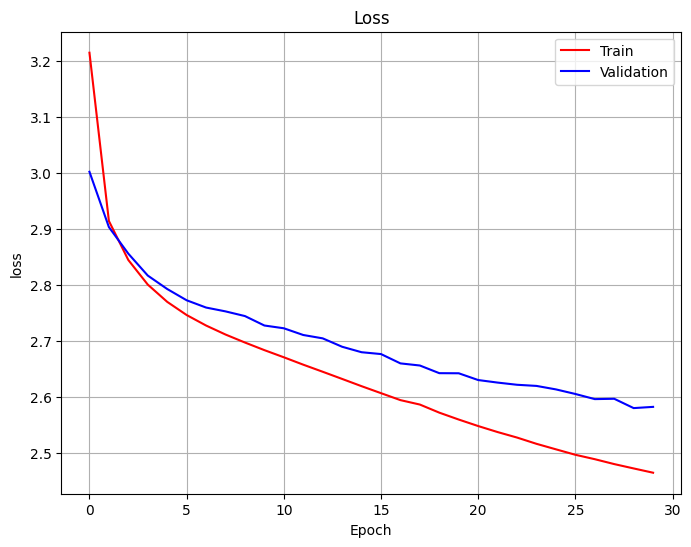

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Loss')
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

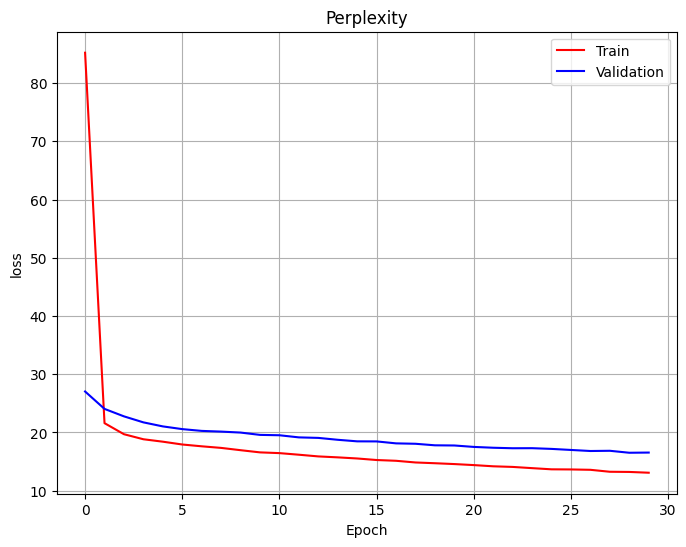

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Perplexity')
plt.plot(range(epoch_counter), perplexity_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), perplexity_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [ ]:

test_loss, test_perplexity = evaluate(model, test_loader, loss_fn, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {test_perplexity:.4f}")


Test Loss: 2.5006
Test Perplexity: 16.2833


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [ ]:
model = LanguageModel(len(vocab), 128, 256, 2, 0.3)
model_path = 'final_best_model.pt'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab):

    tokens = tokenizer(prompt)
    tokens = [vocab[token] for token in tokens]
    tokens = torch.tensor(tokens).unsqueeze(0)
    model.eval()

    generated = tokens.squeeze(0).tolist()

    for _ in range(max_seq_len):
        outputs = model(tokens)
        last_output = outputs[:, -1, :]
        last_output /= temperature
        probabilities = F.softmax(last_output, dim=-1)
        next_token = torch.multinomial(probabilities, 1).item()
        generated.append(next_token)
        tokens = torch.cat([tokens, torch.tensor([[next_token]])], dim=1)
    generated_text = decode_tokens(torch.tensor(generated), vocab)

    return generated_text

def decode_tokens(tokens, vocab, remove_special_tokens=True):
    words = [vocab.get_itos()[token.item()] for token in tokens]
    if remove_special_tokens:
        words = [word for word in words if word not in ['<unk>', '<pad>', '<bos>', '<eos>']]

    return " ".join(words)



In [ ]:
prompt = "Artificial intelligence is"
max_seq_len = 15
temperature = 0.8

generated_text = generate(
    prompt=prompt,
    max_seq_len=max_seq_len,
    temperature=temperature,
    model=model,
    tokenizer=tokenizer,
    device=device
)
print((generated_text).lower())

artificial intelligence is a new challenge and it is one of the major challenges in the field of
